In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
print(torch.__version__)
from torchsummary import summary
from torchvision.utils import save_image
import seaborn as sns


1.8.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change path as required
path = '/content/drive/MyDrive/ecg/'

In [4]:
# Load these files that are generated by the Sampling MLII Beats Only for Generative Models Notebook
train_mlii = np.loadtxt(path+ "train_test_sampled_mlii/train_mlii.csv", delimiter=',')
test_mlii = np.loadtxt(path+"train_test_sampled_mlii/test_mlii.csv", delimiter=',')

print(train_mlii.shape)
print(test_mlii.shape)

(28936, 259)
(27207, 259)


In [5]:
X_train_old = train_mlii[:,:-3]
y_train_old = train_mlii[:,-3]
X_test_old = test_mlii[:,:-3]
y_test_old = test_mlii[:,-3]

In [6]:
# Set num to the class number you want to train the VAE on
# Options: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, None
# None option trains on all classes together
num = None

In [7]:
if num is not None:
  y_train = y_train_old[np.where(y_train_old == num)[0]]
  X_train = X_train_old[np.where(y_train_old == num)[0]]
  X_test = X_test_old[np.where(y_test_old == num)[0]]
  y_test = y_test_old[np.where(y_test_old == num)[0]]
else:
  y_train = y_train_old
  X_train = X_train_old
  X_test = X_test_old
  y_test = y_test_old

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28936, 256)
(28936,)
(27207, 256)
(27207,)


In [9]:
X_train = np.expand_dims(X_train,axis=1)
print(X_train.shape)
X_test = np.expand_dims(X_test, axis=1)
print(X_test.shape)

(28936, 1, 256)
(27207, 1, 256)


In [10]:
# NC = 1    # channels
# NEF = 30  # init encoding filters
# NDF = 30  # init decoding filters

class VAE(nn.Module):
    
    def __init__(self, zdims, number_of_features, hidden_size, hidden_layer_depth, sequence_length, batch_size, dropout, beta, beta_delta):
        super(VAE, self).__init__()
        
        self.zdims = zdims
        self.number_of_features = number_of_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.sequence_length = sequence_length
        self.batch_size=batch_size
        self.beta = beta
        self.beta_delta = beta_delta


        self.encoder = nn.LSTM(self.number_of_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)


        self.decoder = self.model = nn.LSTM(1, self.hidden_size, self.hidden_layer_depth)
        
        # conv fc
        self.fc11 = nn.Linear(self.hidden_size, self.zdims) # mu
        self.fc12 = nn.Linear(self.hidden_size, self.zdims) # logvar
        
        # deconv fc
        self.fc2  = nn.Linear(self.zdims, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, self.number_of_features)

        self.decoder_inputs = torch.zeros(self.sequence_length, self.batch_size, 1, requires_grad=True).type(torch.cuda.FloatTensor)
        self.c_0 = torch.zeros(self.hidden_layer_depth, self.batch_size, self.hidden_size, requires_grad=True).type(torch.cuda.FloatTensor)



    def encode(self, x):

        _, (h_end, c_end) = self.encoder(x)

        h_end = h_end[-1, :, :] 

        mu = self.fc11(h_end)
        logvar = self.fc12(h_end)

        return mu, logvar
    
    def decode(self, z):

        h_state = F.relu(self.fc2(z))


        h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth)])
        decoder_output, _ = self.model(self.decoder_inputs, (h_0, self.c_0))


        out = self.fc3(decoder_output)
        return out


    
    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.rand_like(std)
        z = eps.mul(std).add(mu)
        return z
    
    def forward(self, x):

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        recon_x = self.decode(z)

        return recon_x, mu, logvar, z

    def update_beta(self):
      self.beta += self.beta_delta

In [11]:
print(X_train.shape)

(28936, 1, 256)


In [12]:
CUDA = True

ZDIMS = 30
LR = 0.00001
BATCH_SIZE = 64
SEED = 4
LOG_INTERVAL = 100



hidden_size = 90
hidden_layer_depth = 4
batch_size = 64

dropout_rate = 0.2

sequence_length = X_train.shape[1]
features = X_train.shape[2]
beta=0.1
beta_delta=0

In [13]:
torch.manual_seed(SEED)
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [14]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [15]:
tensor_Xtest = torch.from_numpy(X_test)
tensor_ytest = torch.from_numpy(y_test)

test_data = Data.TensorDataset(tensor_Xtest, tensor_ytest)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [16]:
model = VAE(zdims = ZDIMS, number_of_features=features,hidden_size=hidden_size, hidden_layer_depth=hidden_layer_depth, sequence_length= sequence_length, batch_size=batch_size, dropout=dropout_rate, beta=beta, beta_delta=beta_delta).to(device)
optimizer = optim.Adam(model.parameters(), lr = LR)

In [17]:
print(model)

VAE(
  (encoder): LSTM(256, 90, num_layers=4, dropout=0.2)
  (decoder): LSTM(1, 90, num_layers=4)
  (model): LSTM(1, 90, num_layers=4)
  (fc11): Linear(in_features=90, out_features=30, bias=True)
  (fc12): Linear(in_features=90, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=256, bias=True)
)


In [18]:
def loss_function(recon_x, x, mu, logvar, beta = 1):
    MSE = F.mse_loss(recon_x,x,reduction= 'mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, KLD, MSE

In [19]:
def train(epoch):

    model.train()
    train_loss = 0
    kld_loss = 0
    mse_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):

        data = data.to(device)

        data = data.permute(1,0,2)
        optimizer.zero_grad()

        recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))

        
        loss, kld, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        kld_loss += kld.item()
        mse_loss += mse.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)
            ))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch,
        train_loss / len(train_loader.dataset)
    ))
    return train_loss / len(train_loader.dataset), kld_loss / len(train_loader.dataset), mse_loss / len(train_loader.dataset)

In [20]:
train_loss_list = []
kld_list = []
mse_list = []
for epoch in range(50):
    loss, kld, mse = train(epoch)
    train_loss_list.append(loss)
    kld_list.append(kld)
    mse_list.append(mse)

Train Epoch: 0 [0/28936 (0%)]	Loss: 6.638855
Train Epoch: 0 [100/28936 (22%)]	Loss: 6.125067
Train Epoch: 0 [200/28936 (44%)]	Loss: 5.646133
Train Epoch: 0 [300/28936 (66%)]	Loss: 5.186838
Train Epoch: 0 [400/28936 (88%)]	Loss: 4.733890
====> Epoch: 0 Average loss: 0.0865
Train Epoch: 1 [0/28936 (0%)]	Loss: 4.485738
Train Epoch: 1 [100/28936 (22%)]	Loss: 3.979783
Train Epoch: 1 [200/28936 (44%)]	Loss: 3.469432
Train Epoch: 1 [300/28936 (66%)]	Loss: 2.946972
Train Epoch: 1 [400/28936 (88%)]	Loss: 2.400786
====> Epoch: 1 Average loss: 0.0520
Train Epoch: 2 [0/28936 (0%)]	Loss: 2.216727
Train Epoch: 2 [100/28936 (22%)]	Loss: 1.584093
Train Epoch: 2 [200/28936 (44%)]	Loss: 1.313632
Train Epoch: 2 [300/28936 (66%)]	Loss: 1.259421
Train Epoch: 2 [400/28936 (88%)]	Loss: 1.037391
====> Epoch: 2 Average loss: 0.0208
Train Epoch: 3 [0/28936 (0%)]	Loss: 0.993549
Train Epoch: 3 [100/28936 (22%)]	Loss: 0.714866
Train Epoch: 3 [200/28936 (44%)]	Loss: 0.848956
Train Epoch: 3 [300/28936 (66%)]	Loss: 0

In [21]:
def plot_image(img, ax, title):
    view_data = img
    time_value = np.arange(256, dtype = 'float')
    ax.grid(zorder=0)
    ax.plot(time_value, view_data)
    ax.set_title(title, fontsize=20)


def plot_encoding(image, model, latent_sz, alpha=1, width=1/7):
    image = image[0]
    image.to(device)
    image = image.permute(1,0,2)
    decoded, mu, logvar, z = model.forward(image.type(torch.cuda.FloatTensor))
    z = model.reparameterize(mu, logvar)
    img = model.decode(z).view(-1,256).detach().cpu().numpy()
    z = z.cpu().detach().numpy()[0]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
    
    plot_image(image[0,0,:], ax0, 'Input ECG Beat')
    ax1.bar(np.arange(latent_sz), height=z, width=width, align='center', color='blue')
    ax1.grid(zorder=0)
    ax1.scatter(np.arange(latent_sz), z, color='blue')
    ax1.set_title(r"Latent Dimension %d" % latent_sz, fontsize=20)
    
    plot_image(img[0,:], ax2, 'Decoded ECG Beat')
    plt.subplots_adjust(hspace=0.5)

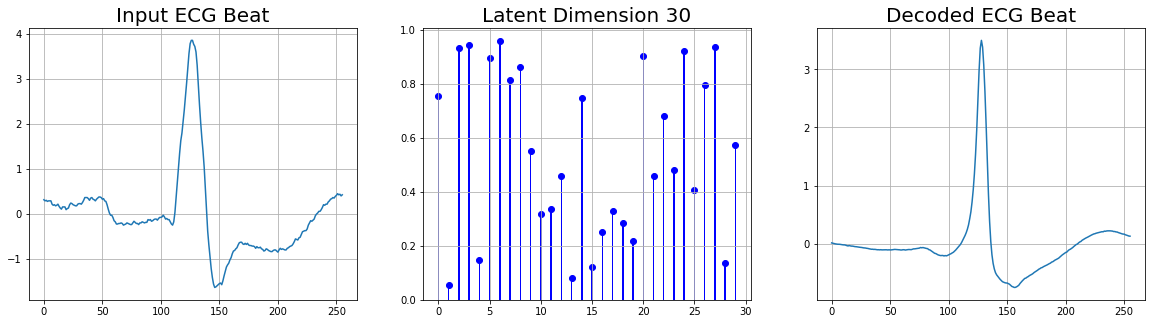

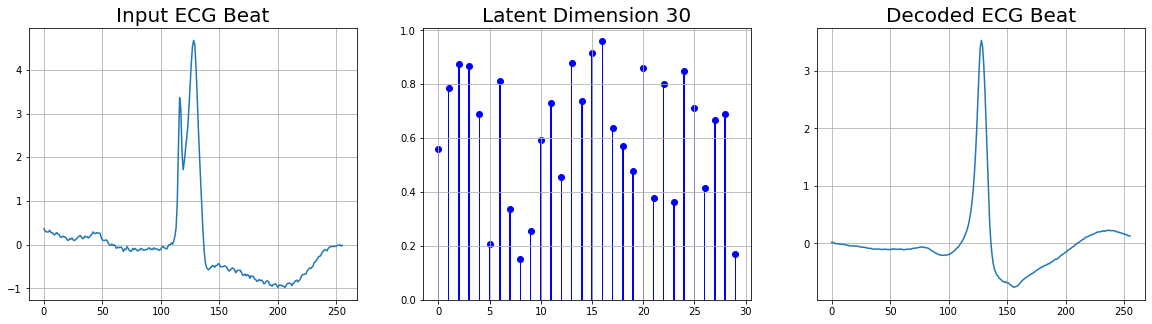

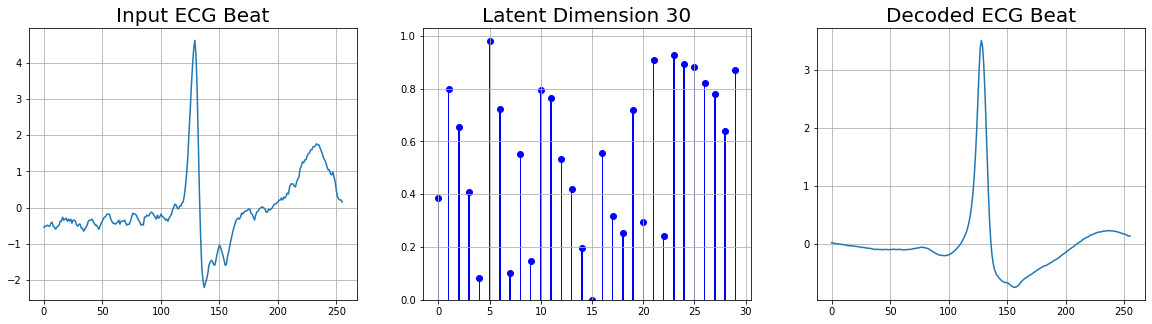

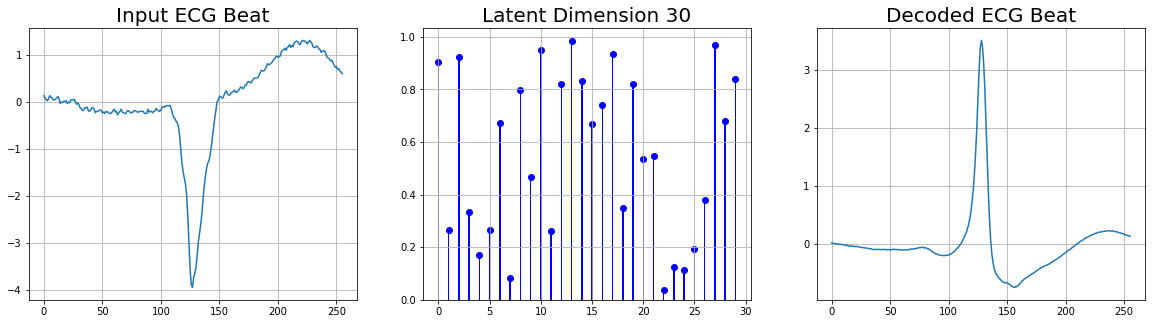

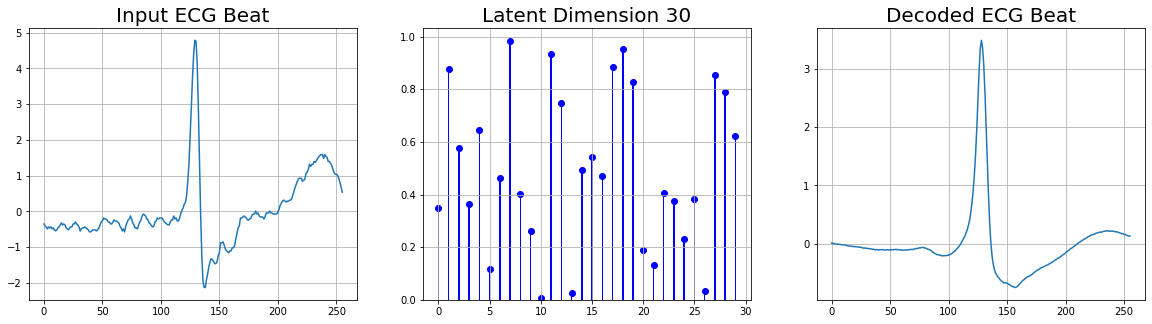

In [22]:
dataloader_iterator = iter(train_loader)
for i in range(5):
    try:
        img = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(train_loader)
        img = next(dataloader_iterator)
    plot_encoding(img, model, ZDIMS)

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
latent_ecg = []
target = []
for data, targets in train_loader:
    z_means, z_logvar = model.encode(data.permute(1,0,2).type(torch.cuda.FloatTensor))

    latent_ecg.extend(z_means.detach().cpu().numpy())
    target.extend(targets.numpy())


latent = np.array(latent_ecg)

target = np.array(target)
tsne = TSNE(n_components=2, random_state=42, verbose=2, n_iter=500, perplexity=100)

X = tsne.fit_transform(latent_ecg)


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 28928 samples in 0.100s...
[t-SNE] Computed neighbors for 28928 samples in 53.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28928
[t-SNE] Computed conditional probabilities for sample 2000 / 28928
[t-SNE] Computed conditional probabilities for sample 3000 / 28928
[t-SNE] Computed conditional probabilities for sample 4000 / 28928
[t-SNE] Computed conditional probabilities for sample 5000 / 28928
[t-SNE] Computed conditional probabilities for sample 6000 / 28928
[t-SNE] Computed conditional probabilities for sample 7000 / 28928
[t-SNE] Computed conditional probabilities for sample 8000 / 28928
[t-SNE] Computed conditional probabilities for sample 9000 / 28928
[t-SNE] Computed conditional probabilities for sample 10000 / 28928
[t-SNE] Computed conditional probabilities for sample 11000 / 28928
[t-SNE] Computed conditional probabilities for sample 12000 / 28928
[t-SNE] Computed conditional probabilities for s

In [24]:
x_pca = PCA(n_components=10,random_state=42).fit_transform(latent_ecg)

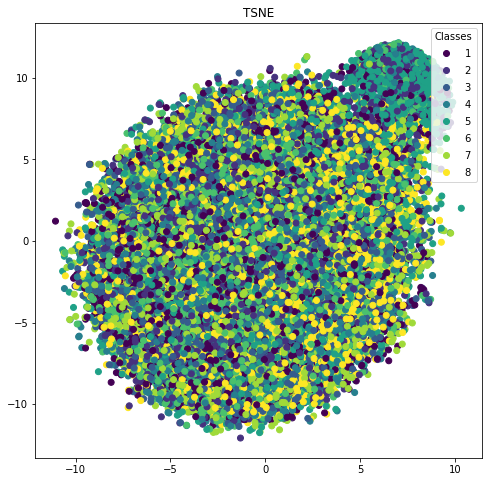

Text(0.5, 1.0, 'PCA')

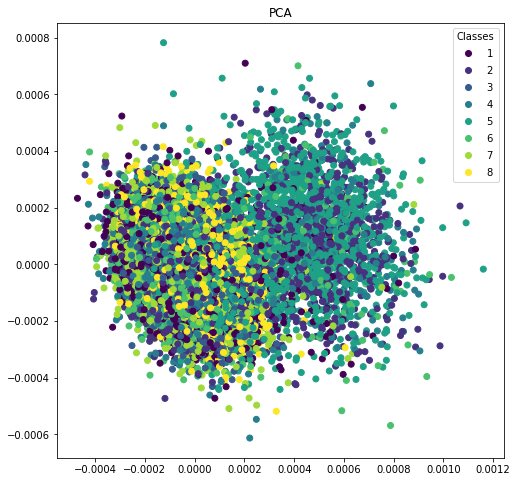

In [25]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(X[:,0], X[:,1], c=target, cmap='viridis')
plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
plt.title('TSNE')
plt.show()

plt.figure(figsize=(8,8))

scatter = plt.scatter(x_pca[:,0],x_pca[:,1],c=target, cmap='viridis')
plt.legend(title="Classes",loc='upper right',*scatter.legend_elements())
plt.title('PCA')

In [26]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    kld_loss_tst = 0
    mse_loss_tst = 0
    recon_list = []
    with torch.no_grad():
        
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            data= data.permute(1,0,2)
            recon_batch, mu, logvar, Z = model(data.type(torch.cuda.FloatTensor))
            recon_list.append(recon_batch)
            loss, kld, mse = loss_function(recon_batch, data.type(torch.cuda.FloatTensor), mu, logvar)
            test_loss += loss.item()
            kld_loss_tst += kld.item()
            mse_loss_tst += mse.item()
          

    if(epoch==99):
      f, a = plt.subplots(2, 5, figsize=(20,5))
      view_data = data[:5].view(-1, 256).type(torch.cuda.FloatTensor)
      view_recon = recon_batch[:5].view(-1, 256).type(torch.cuda.FloatTensor)

      for i in range(5):
          a[0][i].plot(view_data.detach().cpu().numpy()[i])

      for i in range(5):
          a[1][i].clear()
          a[1][i].plot(view_recon.detach().cpu().numpy()[i])
      plt.show();
    test_loss /= len(test_loader.dataset)
    kld_loss_tst /= len(test_loader.dataset)
    mse_loss_tst /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss, kld_loss_tst, mse_loss_tst, recon_list

In [27]:
test_loss_list = []
kld_list_tst = []
mse_list_tst = []
for epoch in range(50):
    loss, kld, mse, recon_list = test(epoch)
    test_loss_list.append(loss)
    kld_list_tst.append(kld)
    mse_list_tst.append(mse)

====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss: 0.0080
====> Test set loss:

In [28]:
copy_recon = recon_list
recon_all = torch.cat(copy_recon, dim=1)
print(recon_all.shape)

torch.Size([1, 27200, 256])


In [29]:
recon_all_1 = torch.squeeze(recon_all, dim=0)
print(recon_all_1.shape)

torch.Size([27200, 256])


In [30]:
def sample_latent(model, no_samples):
  samples = []
  with torch.no_grad():
    for i in range(no_samples // 64):
      sample = torch.randn(64, ZDIMS).to(device)
      sample = model.decode(sample).cpu()
      sample = sample.reshape(-1,256)
      samples.append(sample)
    return samples

In [31]:
samples = sample_latent(model,6000)
print(len(samples))

93


In [32]:
print(samples[0].shape)
all_samps = np.concatenate(samples, axis=0)
print(all_samps.shape)

torch.Size([64, 256])
(5952, 256)


### Saving synthetic data - Change Path As Required

In [33]:
import os
sv_samps = '/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/beat_type' + str(num) + '.csv'
if not os.path.exists('/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/'):
  os.makedirs('/content/drive/MyDrive/ecg/synthetic_data/lstm_vae/')
np.savetxt(sv_samps, all_samps, delimiter=',', fmt='%f')

In [34]:
def view_samples(sample):
  f, a = plt.subplots(1, 5, figsize=(40,5))
  view_data = sample[30:35]

  for i in range(5):
      a[i].plot(view_data[i])

  plt.show();

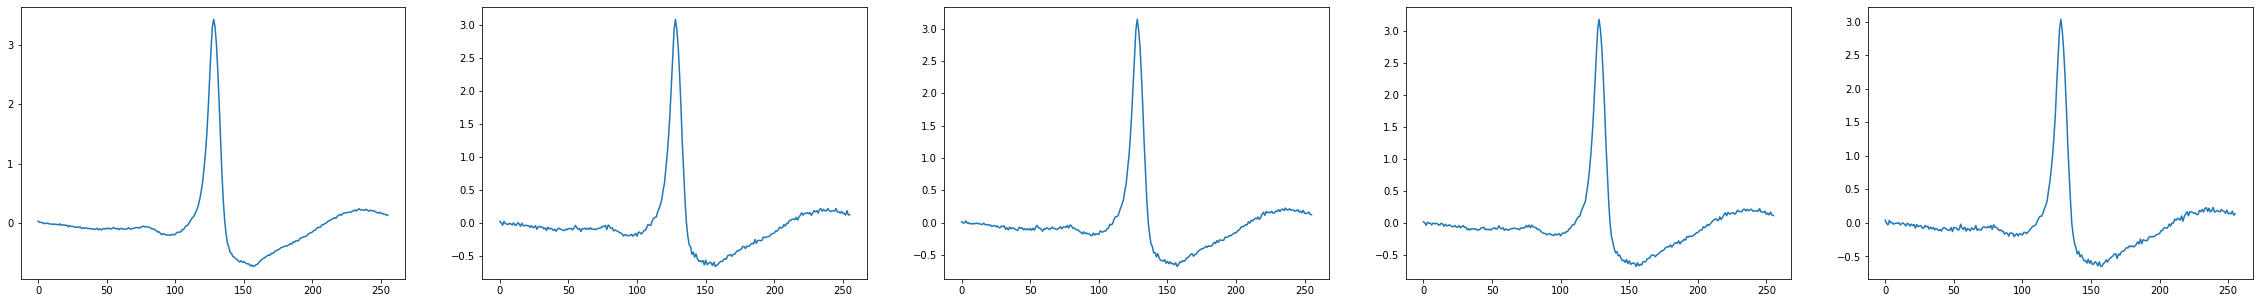

In [35]:
view_samples(all_samps)

## Loss Graphs

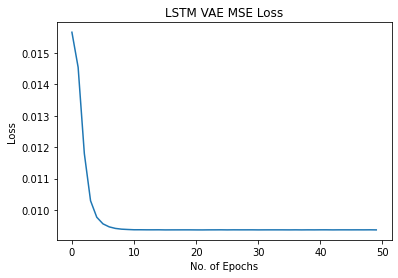

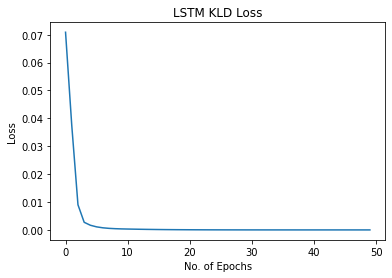

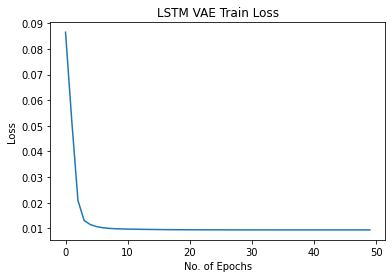

In [36]:
plt.plot(range(len(mse_list)), mse_list)
plt.title("LSTM VAE MSE Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot(range(len(kld_list)), kld_list)
plt.title("LSTM KLD Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.title("LSTM VAE Train Loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.show()

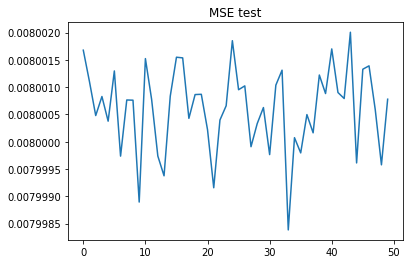

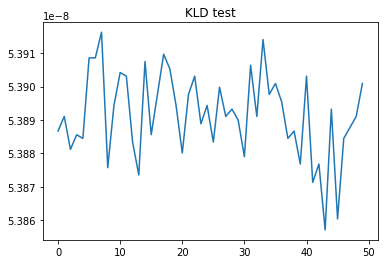

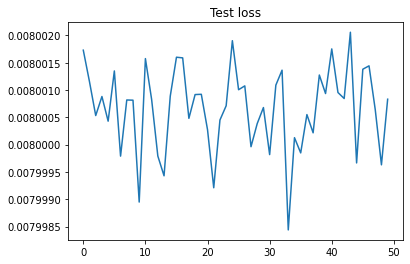

In [37]:
plt.plot(range(len(mse_list_tst)), mse_list_tst)
plt.title("MSE test")
plt.show()
plt.plot(range(len(kld_list_tst)), kld_list_tst)
plt.title("KLD test")
plt.show()
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("Test loss")
plt.show()